In [1]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt


def load_all_data(folder_path, ignore_completed=False):
    """
    Iterate over all .json files in folder_path:
      - By default, include only those with quiz['completed'] == True;
      - Rename answer keys that have numeric suffixes (_1, _2, …)
      - Apply renaming logic for post-task-question and post-task-survey keys

    Returns a dict mapping each filename (without extension) to its processed quiz data dict.
    """
    def extract_suffix(key):
        m = re.search(r'_(\d+)$', key)
        return int(m.group(1)) if m else 0

    def remove_suffix(key):
        return re.sub(r'_(\d+)$', '', key)

    all_data = {}
    for fn in os.listdir(folder_path):
        if not fn.lower().endswith('.json'):
            continue
        path = os.path.join(folder_path, fn)
        try:
            with open(path, encoding='utf-8') as f:
                quiz = json.load(f)
        except json.JSONDecodeError:
            continue

        if not ignore_completed and not quiz.get('completed', False):
            continue

        key_name = os.path.splitext(fn)[0]
        all_data[key_name] = quiz

        answers = quiz.get('answers', {})
        if not isinstance(answers, dict):
            continue

        sorted_keys = sorted(answers.keys(), key=extract_suffix)
        new_answers = {}
        last_task = None
        for i, old in enumerate(sorted_keys):
            base = remove_suffix(old)

            if base == 'post-task-question':
                new_key = f"{last_task}_post-task-question" if last_task else base
            elif base.startswith('post-task-survey'):
                if i > 0:
                    prev = sorted_keys[i-1]
                    prev_base = remove_suffix(prev)
                    suffix = prev_base[prev_base.rfind('-'):] if '-' in prev_base else ''
                    new_key = base + suffix
                else:
                    new_key = base
                last_task = None
            else:
                new_key = base
                last_task = base

            new_answers[new_key] = answers[old]

        quiz['answers'] = new_answers

    return all_data

def time_analysis(all_data, metric='total_duration_min'):
    """
    Parameters:
      all_data (dict): The dictionary returned by load_quiz_data.

    Returns:
      df_task_level (pandas.DataFrame):
        A DataFrame with one row per task, including columns for start time, end time, duration, and format.
      df_participant_level (pandas.DataFrame):
        A DataFrame with one row per participant, including columns for total duration and format.
    """
    task_rows = []
    part_rows = []

    for fn, quiz in all_data.items():
        answers = quiz.get('answers', {})
        # look for participantId
        pid = fn
        for info in answers.values():
            if isinstance(info, dict):
                ans = info.get('answer', {})
                if isinstance(ans, dict) and 'prolificId' in ans:
                    pid = ans['prolificId']
                    break

        # extract  format
        current_format = None
        total_sec = 0
        temp = []
        for name, info in answers.items():
            if not isinstance(info, dict):
                continue
            st = info.get('startTime')
            ed = info.get('endTime')
            if st is not None and ed is not None:
                dur = (ed - st)/1000.0
            else:
                dur = None

            # tutorial-<fmt>-part1
            if current_format is None:
                m = re.match(r'tutorial-(\w+)-part1', name)
                if m:
                    current_format = m.group(1).lower()

            temp.append({
                'participantId': pid,
                'task': name,
                'startTime': st,
                'endTime': ed,
                'duration_sec': dur,
                'duration_min': dur/60 if dur is not None else None
            })
            if dur:
                total_sec += dur

        # add format 
        fmt = current_format or 'unknown'
        for row in temp:
            row['format'] = fmt
            task_rows.append(row)

        part_rows.append({
            'participantId': pid,
            'format': fmt,
            'duration_sec': round(total_sec,3),
            'duration_min': round(total_sec/60,2)
        })

    df_task = pd.DataFrame(task_rows)
    df_part = pd.DataFrame(part_rows)
    def clean(name, fmt):
        if fmt and fmt!='unknown':
            return name.replace(f"-{fmt}", "")
        return name

    df_task['task'] = df_task.apply(lambda r: clean(r['task'], r['format']), axis=1)
    format_stat = df_part['format'].value_counts()
    total_participant = len(df_part)
    print(f"Total number of valid participants: {total_participant}")

    return df_task, df_part, format_stat



In [2]:
import sys
sys.path.append('/Users/shiyihe/Desktop/USABILITY_ANALYSIS')   

# load data , rename task name, etc,.
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_all_data(folder, ignore_completed=True)
df_task, df_part, format_stat= time_analysis(all_data)
df_task

Total number of valid participants: 106


,participantId,task,startTime,endTime,duration_sec,duration_min,format
0,64457bc906c125cebd4bf66b,introduction,1746559492770,1746559515399,22.629,0.377150,json5
1,64457bc906c125cebd4bf66b,qualifications,1746559515600,1746559523566,7.966,0.132767,json5
2,64457bc906c125cebd4bf66b,consent,1746559523735,1746559534847,11.112,0.185200,json5
3,64457bc906c125cebd4bf66b,task,1746559535031,1746559541217,6.186,0.103100,json5
4,64457bc906c125cebd4bf66b,writing-task-NL,1746559541303,1746559656705,115.402,1.923367,json5
...,...,...,...,...,...,...,...
3281,6675c40cdc52b37294f0514e,modifying-task-tabular-4,1746235729585,1746235939094,209.509,3.491817,hjson
3282,6675c40cdc52b37294f0514e,modifying-task-tabular-4_post-task-question,1746235939448,1746235944746,5.298,0.088300,hjson
3283,6675c40cdc52b37294f0514e,$nasa-tlx.co.nasa-tlx,1746235945130,1746235958400,13.270,0.221167,hjson
3284,6675c40cdc52b37294f0514e,post-task-survey-tlx,1746235958794,1746236001871,43.077,0.717950,hjson


In [25]:
# df_part
# format_stat

,participantId,format,duration_sec,duration_min
0,64457bc906c125cebd4bf66b,json5,1570.084,26.17
1,6697c8b6d9d7baa7edd8c4d3,hjson,4695.463,78.26
2,67e25388d573ec2d5f1c8442,yaml,4214.973,70.25
3,67e5cf90b79d0874e1cf16b0,toml,4366.063,72.77
4,67d00f24466a67ba7e41228e,toml,4482.184,74.70
...,...,...,...,...
101,67ab650c320eccf6141d4010,jsonc,3356.075,55.93
102,65fad673a546ab14baf2f8d3,json5,3510.722,58.51
103,67f1c7bd6f1c4a3d8deae02f,toml,3569.983,59.50
104,67adb27bd5f5776fcb16da62,hjson,3737.170,62.29


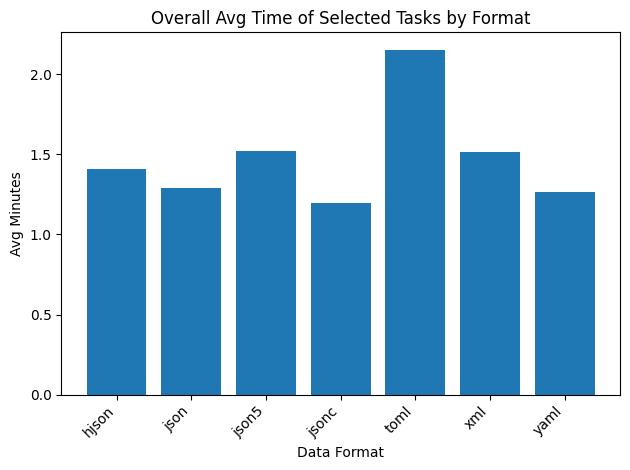

,format,average_duration_min
0,hjson,1.408947
1,json,1.289103
2,json5,1.520697
3,jsonc,1.195805
4,toml,2.154509
5,xml,1.515769
6,yaml,1.265393


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple

def summarize_and_plot_tasks_by_format(
    df_task: pd.DataFrame,
    task_list: list,
    metric: str = 'duration_min',
    mode: str = 'overall',
    title: str = 'Average Time by Format',
    xlabel: str = 'Format',
    ylabel: str = None
) -> Tuple[pd.DataFrame, plt.Figure]:
    """
    1) 对 df_task 进行过滤，仅保留 task_list 中的任务；
    2) 根据 mode 计算平均值：
       - 'overall'：按 format 分组，计算 metric 的平均值，列名为 average_<metric>
       - 'by_task'：按 ['format','task'] 分组，计算 metric 的平均值，列名为 average_<metric>
    3) 绘制柱状图：
       - 'overall'：每个 format 一根柱
       - 'by_task'：每个 format 下不同 task 分组柱状图
    返回 (summary_df, fig)
    """
    avg_col = f'average_{metric}'
    # 1) 过滤
    df_filtered = df_task[df_task['task'].isin(task_list)]
    
    # 2) 汇总
    if mode == 'overall':
        summary = (
            df_filtered
            .groupby('format')[metric]
            .mean()
            .reset_index()
            .rename(columns={metric: avg_col})
        )
    elif mode == 'by_task':
        summary = (
            df_filtered
            .groupby(['format', 'task'])[metric]
            .mean()
            .reset_index()
            .rename(columns={metric: avg_col})
        )
    else:
        raise ValueError("mode must be 'overall' or 'by_task'")
    
    # 3) 绘图
    fig, ax = plt.subplots()
    if mode == 'overall':
        ax.bar(summary['format'], summary[avg_col])
    else:
        pivot = summary.pivot(index='format', columns='task', values=avg_col)
        pivot.plot(kind='bar', ax=ax)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel or f'Average {metric}')
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return summary, fig



summary_df, fig = summarize_and_plot_tasks_by_format(
    df_task,
    task_list=['reading-task-tabular-1', 'reading-task-tabular-2', 'reading-task-tabular-3', 'reading-task-tabular-4', 'reading-task-tabular-5'],
    metric='duration_min',
    mode='overall', # overall or by_task
    title='Overall Avg Time of Selected Tasks by Format',
    xlabel='Data Format',
    ylabel='Avg Minutes'
)
plt.show()

summary_df

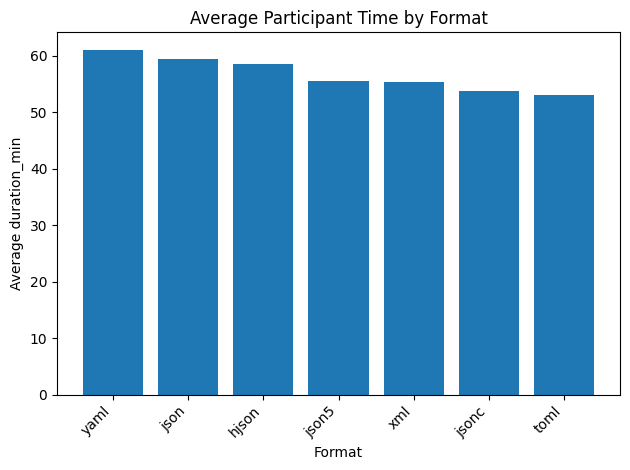

In [4]:
def summarize_and_plot_participant_time_by_format(df_part,
                                    metric='duration_min',
                                    title='Average Participant Time by Format',
                                    xlabel='Format',
                                    ylabel=None):
    """
    Plot a bar chart of average participant times by format,
    supporting custom chart title and axis labels.
    """
    summary = df_part.groupby('format')[metric].mean().reset_index()
    avg_col = f'{metric}'
    summary = summary.rename(columns={metric: avg_col})
    df_summary=summary.sort_values(by=avg_col, ascending=False)
    fig, ax = plt.subplots()
    ax.bar(df_summary['format'], df_summary[metric])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel or f'Average {metric}')
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return fig

fig = summarize_and_plot_participant_time_by_format(df_part,
                                    metric='duration_min',
                                    title='Average Participant Time by Format',
                                    xlabel='Format',
                                    ylabel=None)

plt.show()

In [5]:
df_task

,participantId,task,startTime,endTime,duration_sec,duration_min,format
0,64457bc906c125cebd4bf66b,introduction,1746559492770,1746559515399,22.629,0.377150,json5
1,64457bc906c125cebd4bf66b,qualifications,1746559515600,1746559523566,7.966,0.132767,json5
2,64457bc906c125cebd4bf66b,consent,1746559523735,1746559534847,11.112,0.185200,json5
3,64457bc906c125cebd4bf66b,task,1746559535031,1746559541217,6.186,0.103100,json5
4,64457bc906c125cebd4bf66b,writing-task-NL,1746559541303,1746559656705,115.402,1.923367,json5
...,...,...,...,...,...,...,...
3281,6675c40cdc52b37294f0514e,modifying-task-tabular-4,1746235729585,1746235939094,209.509,3.491817,hjson
3282,6675c40cdc52b37294f0514e,modifying-task-tabular-4_post-task-question,1746235939448,1746235944746,5.298,0.088300,hjson
3283,6675c40cdc52b37294f0514e,$nasa-tlx.co.nasa-tlx,1746235945130,1746235958400,13.270,0.221167,hjson
3284,6675c40cdc52b37294f0514e,post-task-survey-tlx,1746235958794,1746236001871,43.077,0.717950,hjson


In [6]:
df_part

,participantId,format,duration_sec,duration_min
0,64457bc906c125cebd4bf66b,json5,1570.084,26.17
1,6697c8b6d9d7baa7edd8c4d3,hjson,4695.463,78.26
2,67e25388d573ec2d5f1c8442,yaml,4214.973,70.25
3,67e5cf90b79d0874e1cf16b0,toml,4366.063,72.77
4,67d00f24466a67ba7e41228e,toml,4482.184,74.70
...,...,...,...,...
101,67ab650c320eccf6141d4010,jsonc,3356.075,55.93
102,65fad673a546ab14baf2f8d3,json5,3510.722,58.51
103,67f1c7bd6f1c4a3d8deae02f,toml,3569.983,59.50
104,67adb27bd5f5776fcb16da62,hjson,3737.170,62.29


In [7]:
df_task['task'].unique()

array(['introduction', 'qualifications', 'consent', 'task',
       'writing-task-NL', 'writing-task-NL_post-task-question',
       'tutorial-part1', 'tutorial-part2', 'reading-task-tabular-1',
       'reading-task-tabular-1_post-task-question',
       'reading-task-tabular-2',
       'reading-task-tabular-2_post-task-question',
       'reading-task-tabular-3',
       'reading-task-tabular-3_post-task-question',
       'reading-task-tabular-4',
       'reading-task-tabular-4_post-task-question',
       'reading-task-tabular-5',
       'reading-task-tabular-5_post-task-question',
       'writing-task-tabular', 'writing-task-tabular_post-task-question',
       'modifying-task-tabular-1',
       'modifying-task-tabular-1_post-task-question',
       'modifying-task-tabular-2',
       'modifying-task-tabular-2_post-task-question',
       'modifying-task-tabular-3',
       'modifying-task-tabular-3_post-task-question',
       'modifying-task-tabular-4',
       'modifying-task-tabular-4_post-t

In [8]:
import pandas as pd

def aggregate_tabular_tasks(df_task: pd.DataFrame) -> pd.DataFrame:
    """
    1) 丢弃 startTime, endTime 列
    2) 对 reading-task-tabular-1..5 按 participantId+format 分组求和，并新增 task=reading-task-tabular
    3) 对 modifying-task-tabular-1..4 同理
    4) 返回拼接好的 DataFrame
    """
    # 1) 丢弃多余列
    df = df_task.drop(columns=['startTime', 'endTime'])
    
    # 2) 筛选并汇总 reading-task-tabular-1..5
    mask_read = df['task'].str.match(r'^reading-task-tabular-[1-5]$')
    agg_read = (
        df[mask_read]
        .groupby(['participantId', 'format'], as_index=False)
        .agg({'duration_sec': 'sum', 'duration_min': 'sum'})
    )
    agg_read['task'] = 'reading-task-tabular'
    
    # 3) 筛选并汇总 modifying-task-tabular-1..4
    mask_mod = df['task'].str.match(r'^modifying-task-tabular-[1-4]$')
    agg_mod = (
        df[mask_mod]
        .groupby(['participantId', 'format'], as_index=False)
        .agg({'duration_sec': 'sum', 'duration_min': 'sum'})
    )
    agg_mod['task'] = 'modifying-task-tabular'
    
    # 4) 拼接原始数据和新汇总行
    # 确保列顺序一致
    cols = ['participantId', 'task', 'duration_sec', 'duration_min', 'format']
    result = pd.concat([
        df[cols],
        agg_read[cols],
        agg_mod[cols]
    ], ignore_index=True)
    
    return result


result= aggregate_tabular_tasks(df_task)
result

,participantId,task,duration_sec,duration_min,format
0,64457bc906c125cebd4bf66b,introduction,22.629,0.377150,json5
1,64457bc906c125cebd4bf66b,qualifications,7.966,0.132767,json5
2,64457bc906c125cebd4bf66b,consent,11.112,0.185200,json5
3,64457bc906c125cebd4bf66b,task,6.186,0.103100,json5
4,64457bc906c125cebd4bf66b,writing-task-NL,115.402,1.923367,json5
...,...,...,...,...,...
3493,67f1a4f8dd44e7cd5adffa29,modifying-task-tabular,452.122,7.535367,json5
3494,67f1c7bd6f1c4a3d8deae02f,modifying-task-tabular,1048.292,17.471533,toml
3495,67f3619e16d4ca195fbd1bd0,modifying-task-tabular,1559.474,25.991233,yaml
3496,67f5bb69760b211cdfe8021c,modifying-task-tabular,783.147,13.052450,jsonc


In [9]:
result[result['participantId']=='64457bc906c125cebd4bf66b']

,participantId,task,duration_sec,duration_min,format
0,64457bc906c125cebd4bf66b,introduction,22.629,0.377150,json5
1,64457bc906c125cebd4bf66b,qualifications,7.966,0.132767,json5
2,64457bc906c125cebd4bf66b,consent,11.112,0.185200,json5
3,64457bc906c125cebd4bf66b,task,6.186,0.103100,json5
4,64457bc906c125cebd4bf66b,writing-task-NL,115.402,1.923367,json5
5,64457bc906c125cebd4bf66b,writing-task-NL_post-task-question,8.808,0.146800,json5
6,64457bc906c125cebd4bf66b,tutorial-part1,225.255,3.754250,json5
7,64457bc906c125cebd4bf66b,tutorial-part2,128.872,2.147867,json5
8,64457bc906c125cebd4bf66b,reading-task-tabular-1,14.824,0.247067,json5
9,64457bc906c125cebd4bf66b,reading-task-tabular-1_post-task-question,5.996,0.099933,json5


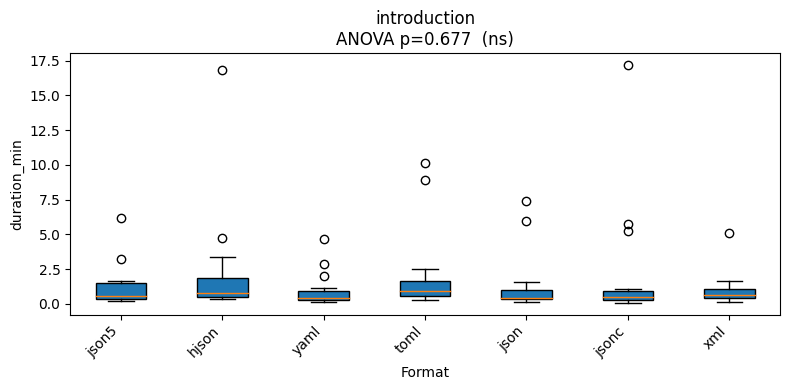

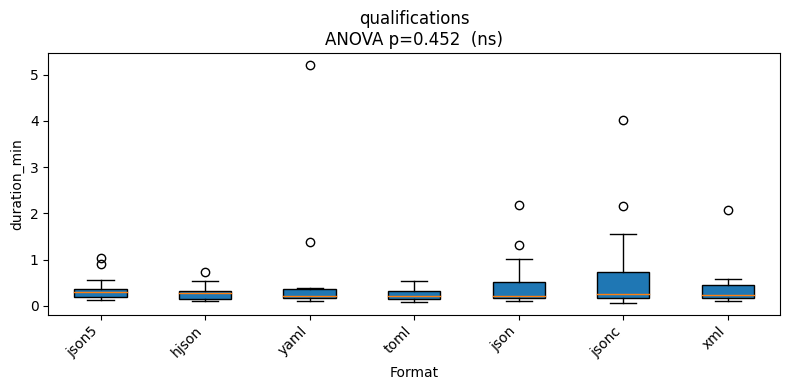

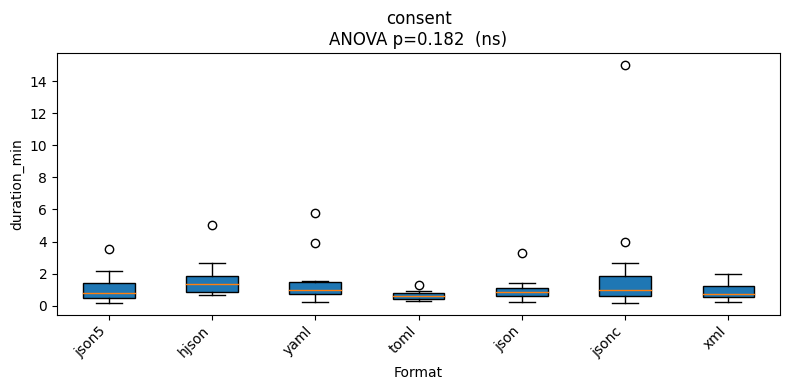

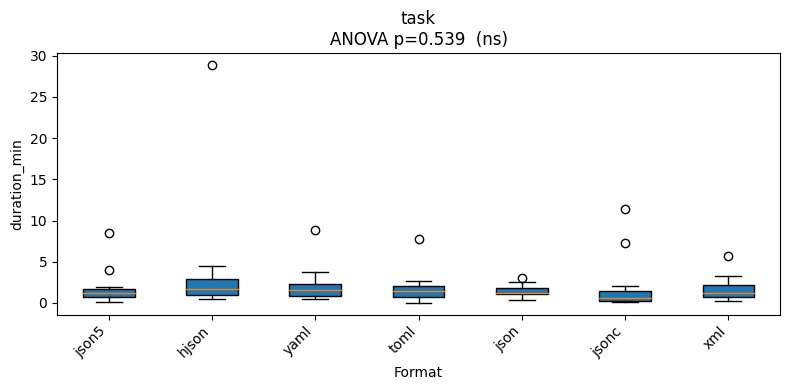

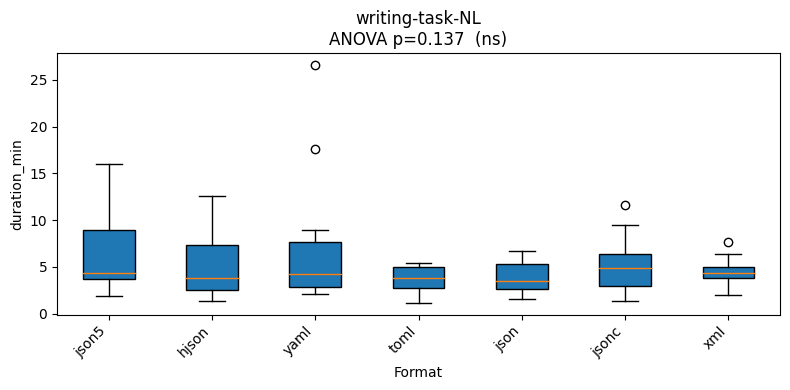

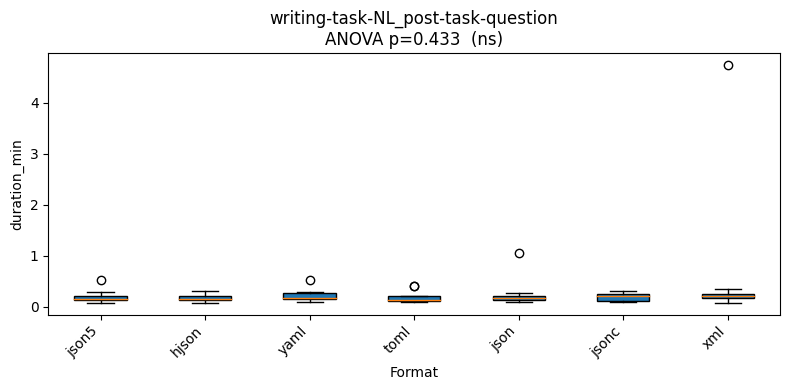

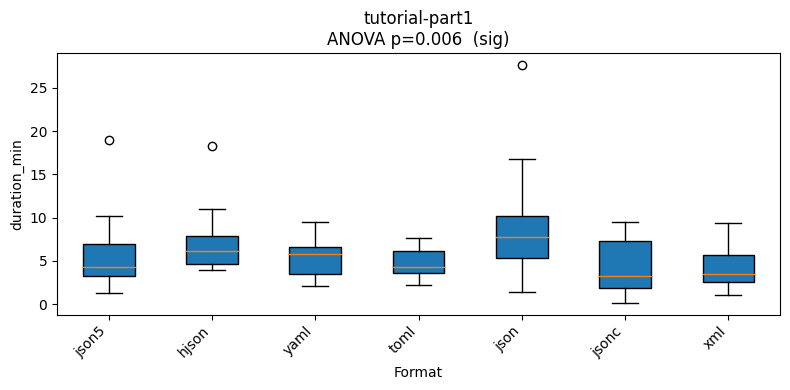

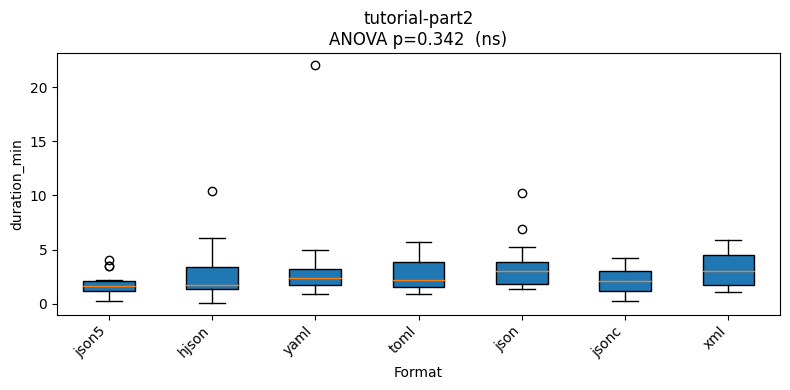

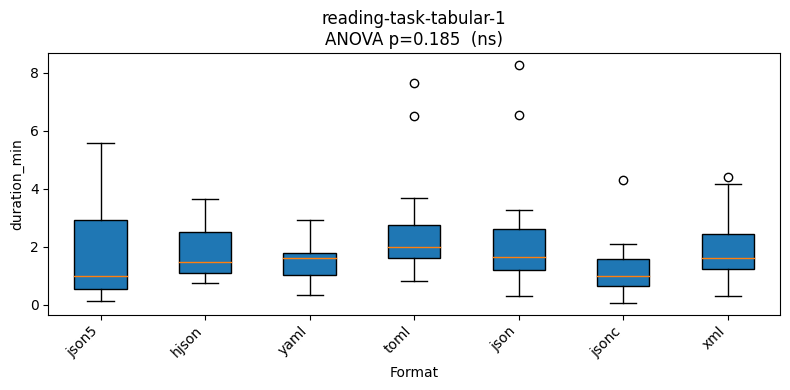

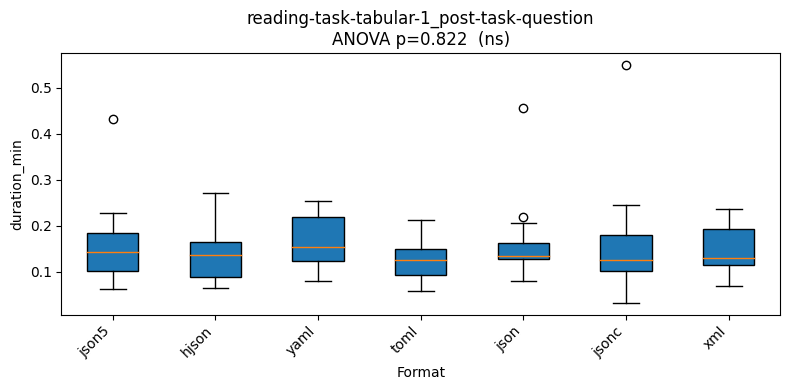

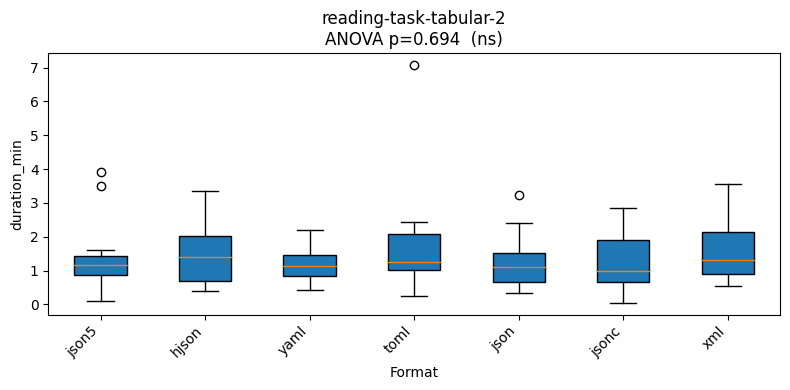

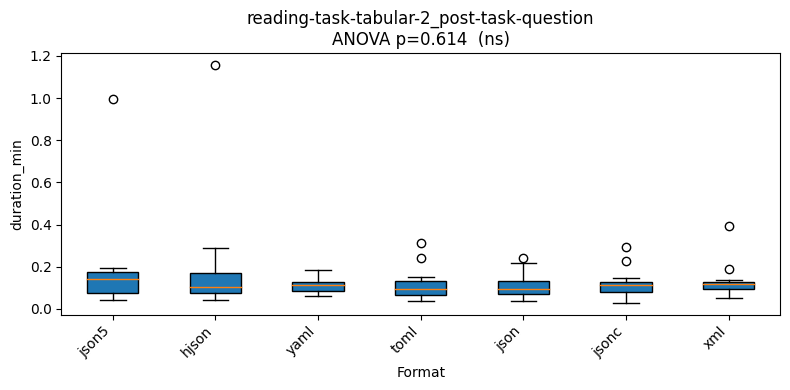

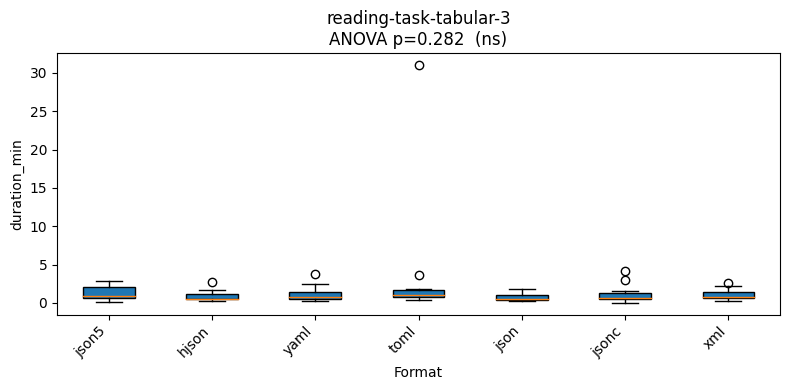

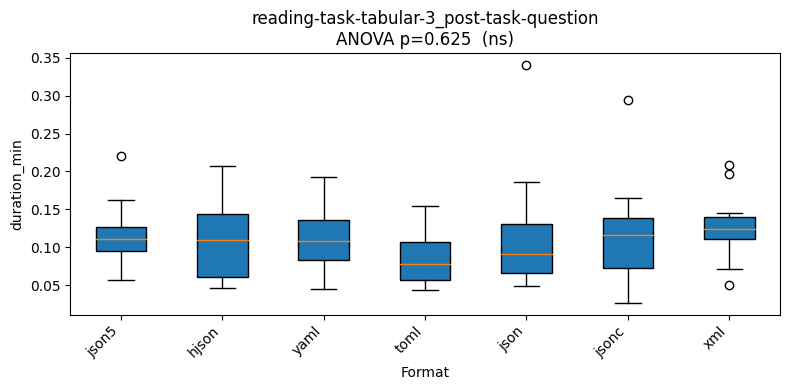

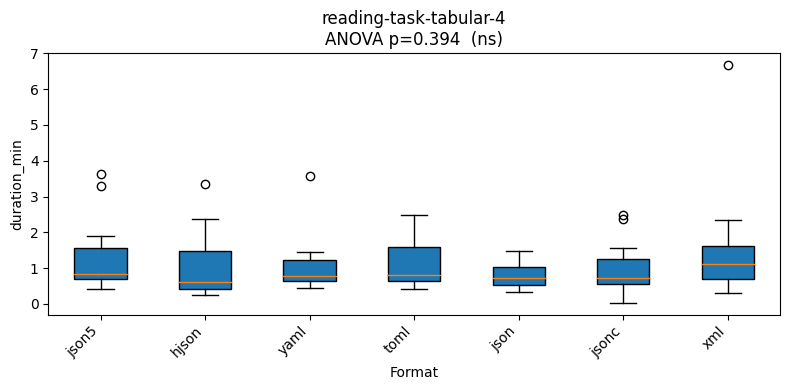

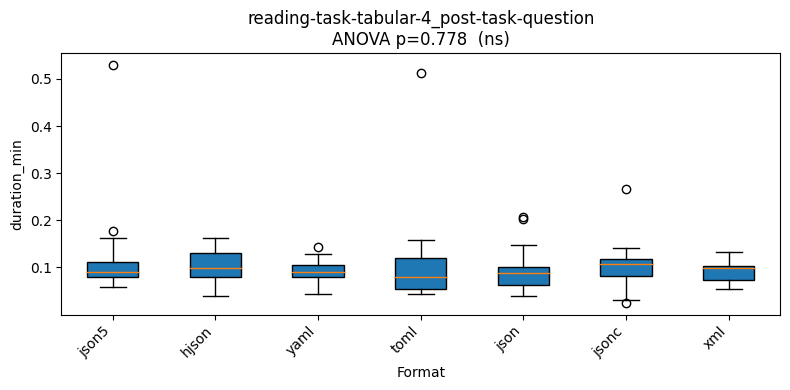

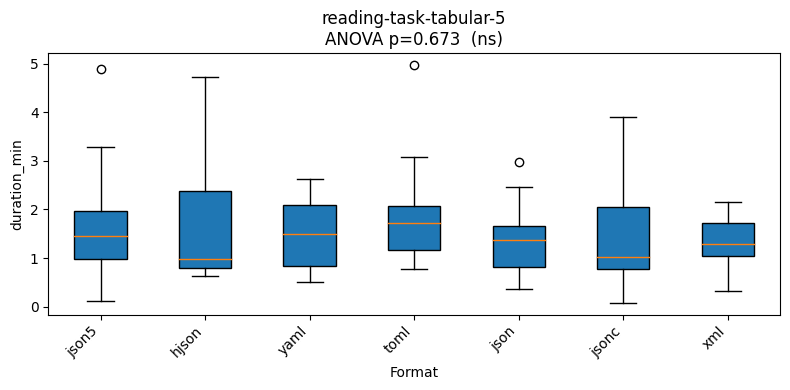

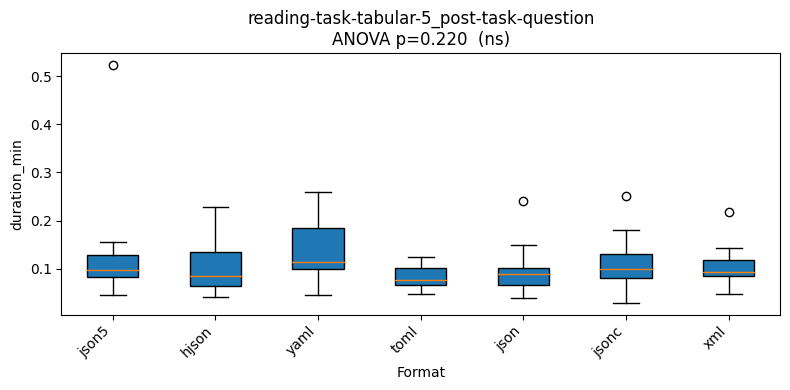

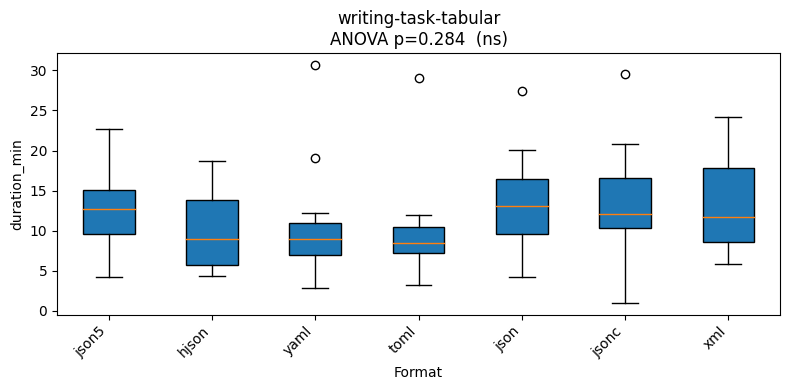

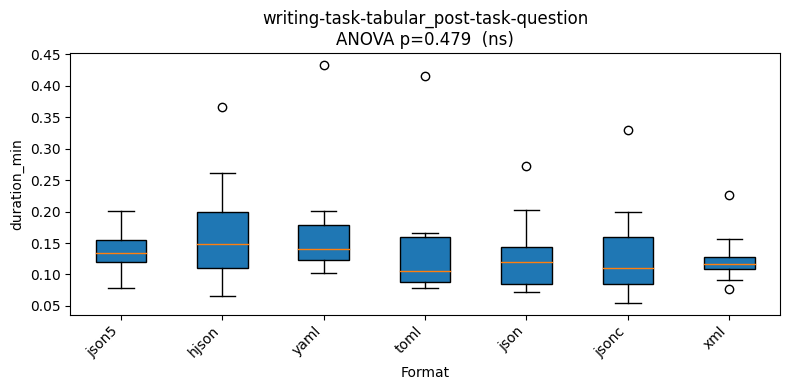

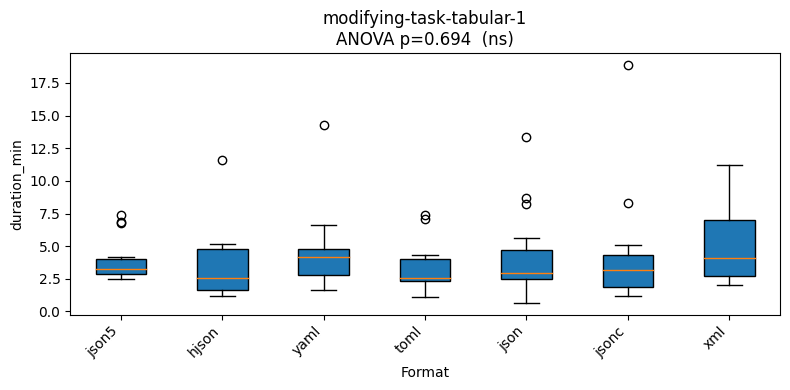

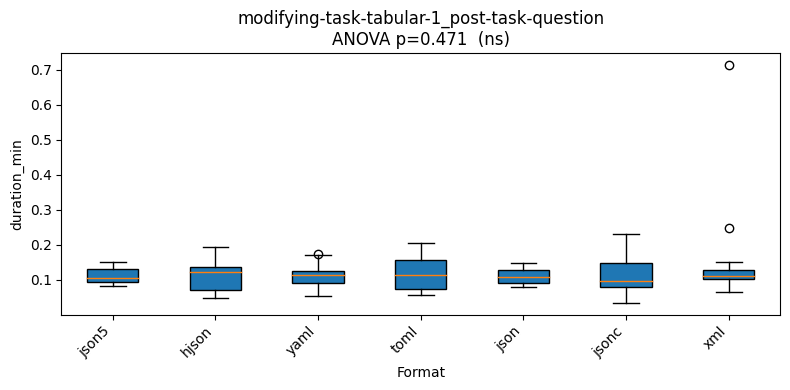

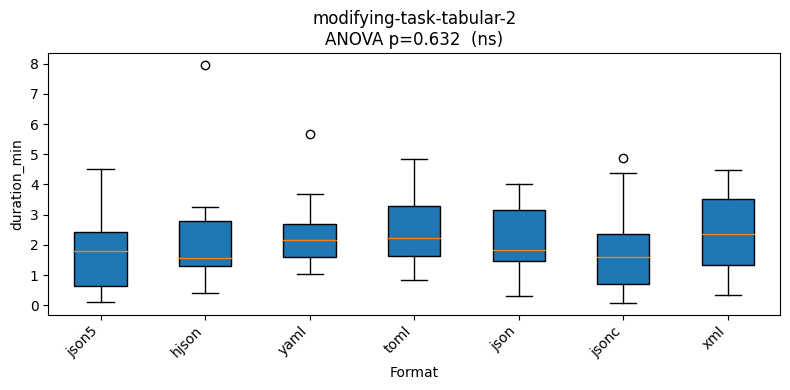

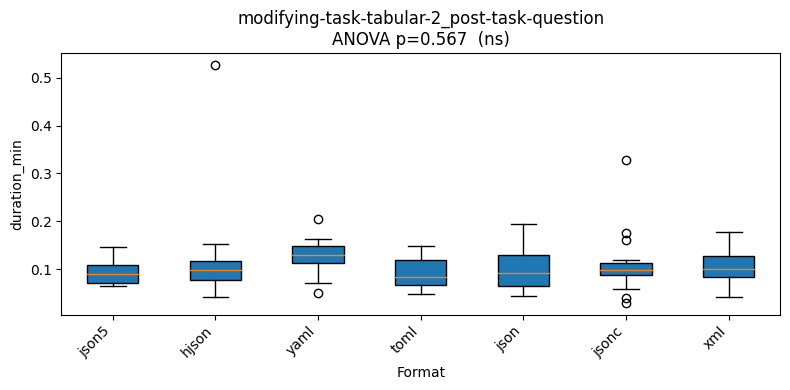

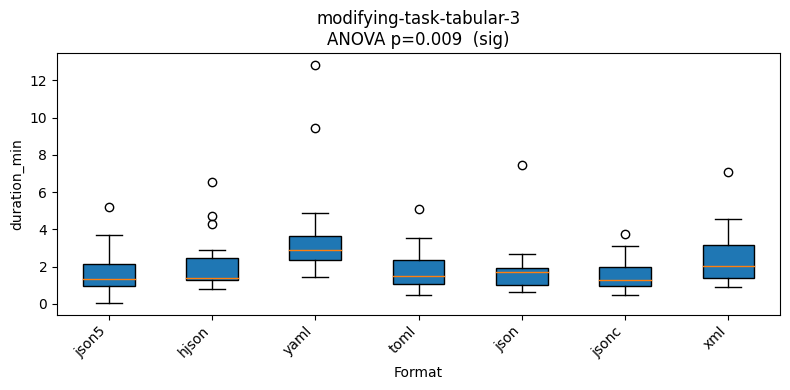

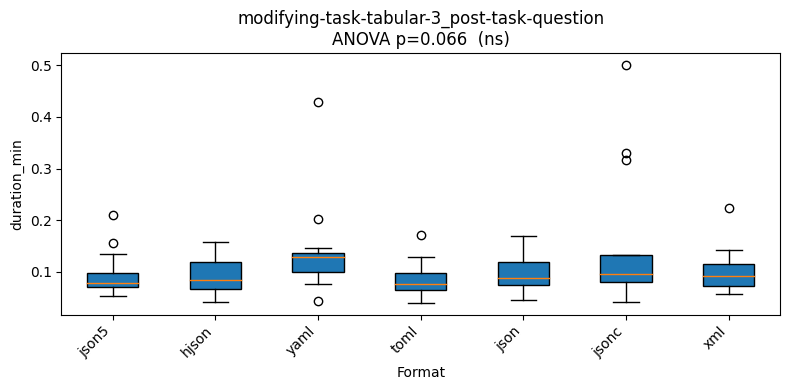

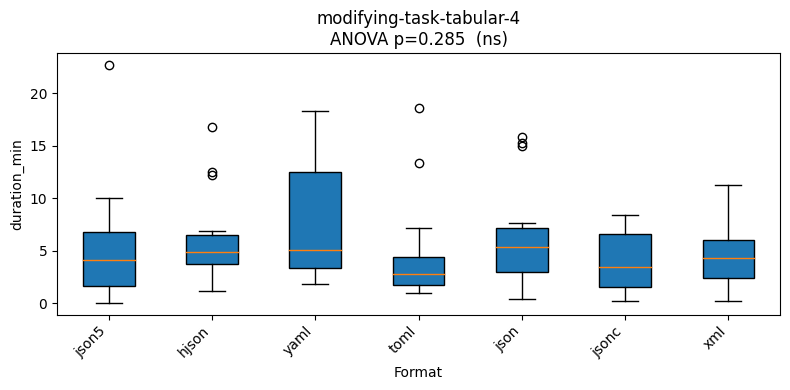

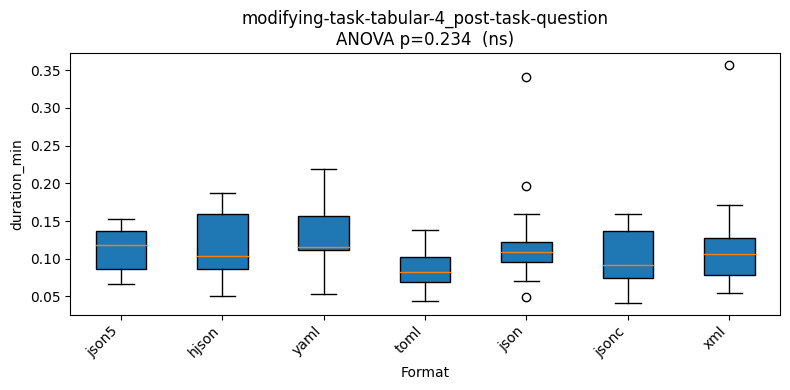

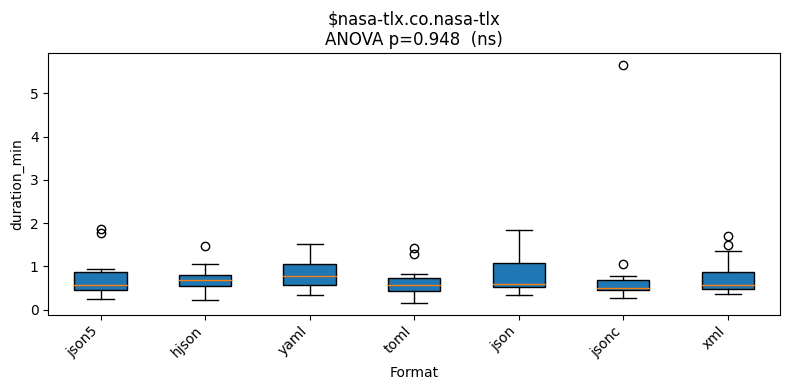

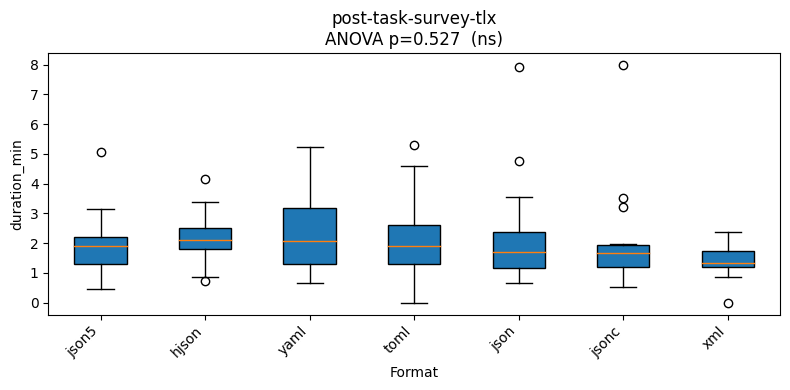

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


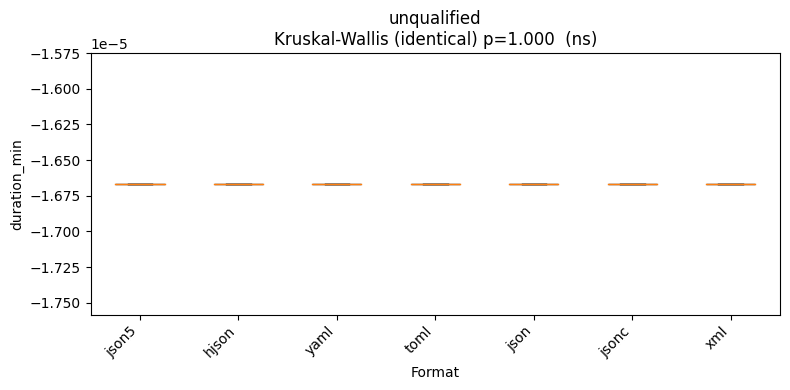

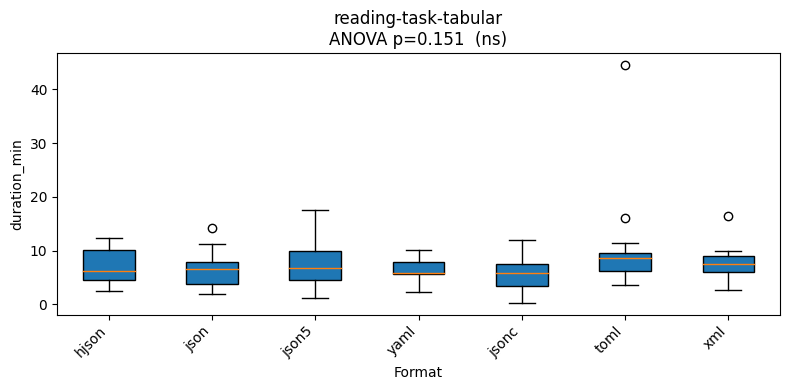

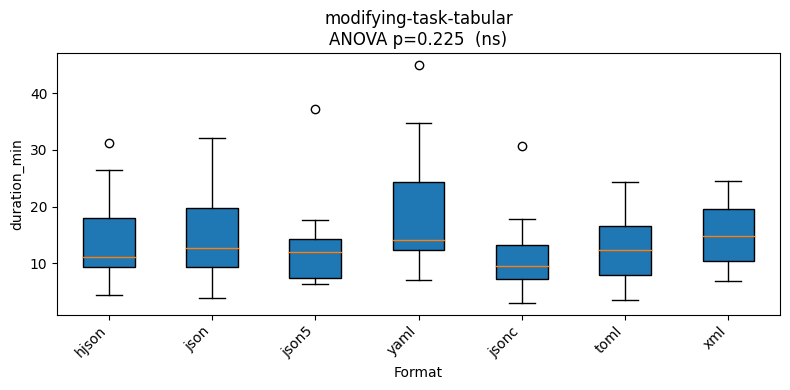

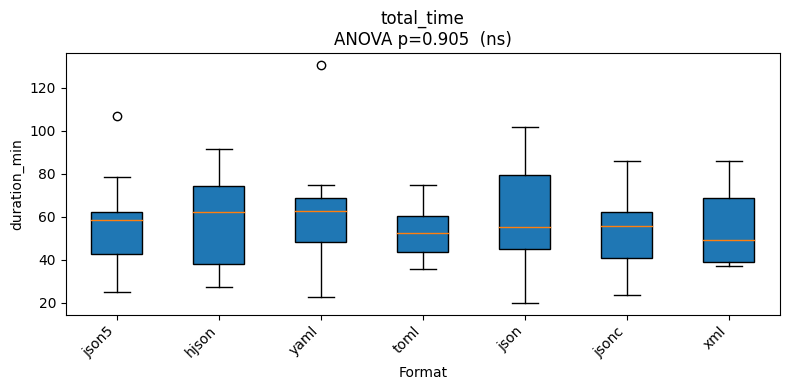

                        task   test    test_p                                                     posthoc
6             tutorial-part1  ANOVA  0.005688                  [json vs jsonc, json vs toml, json vs xml]
24  modifying-task-tabular-3  ANOVA  0.009062  [json vs yaml, json5 vs yaml, jsonc vs yaml, toml vs yaml]


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from scipy.stats import levene, f_oneway, kruskal, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def analyze_time_differences(
    df: pd.DataFrame,
    metric: str = 'duration_min',
    alpha: float = 0.05,
    df_overall: pd.DataFrame = None,
    overall_task_name: str = 'total'
) -> pd.DataFrame:
    """
    对每个 task（包括可选的整体总时长）在不同 format 组间做差异检验，并绘制箱线图。
    已对 kruskal 全部相同值的情况做了捕获，并修复了 Tukey HSD 解析。
    """
    # 1) 合并子任务和总体（如果提供）
    parts = [df[['participantId','task','format',metric]]]
    if df_overall is not None:
        tmp = df_overall[['participantId','format',metric]].copy()
        tmp['task'] = overall_task_name
        parts.append(tmp[['participantId','task','format',metric]])
    df_all = pd.concat(parts, ignore_index=True).dropna(subset=[metric])
    
    records = []
    for task in df_all['task'].unique():
        sub = df_all[df_all['task'] == task]
        groups = sub['format'].unique()
        data_by_fmt = [sub.loc[sub['format']==g, metric].values for g in groups]
        
        # 2) Levene 方差齐性检验
        _, p_lev = levene(*data_by_fmt)
        homogeneity = (p_lev >= alpha)
        
        # 3) 整体差异检验（ANOVA 或 Kruskal-Wallis）
        if homogeneity:
            _, p_main = f_oneway(*data_by_fmt)
            test_name = 'ANOVA'
        else:
            try:
                _, p_main = kruskal(*data_by_fmt)
                test_name = 'Kruskal-Wallis'
            except ValueError as e:
                # 全部值相同时，直接设为不显著
                if 'All numbers are identical' in str(e):
                    p_main = 1.0
                    test_name = 'Kruskal-Wallis (identical)'
                else:
                    raise
        
        sig = (p_main < alpha)
        
        # 4) 事后成对比较
        posthoc = []
        if sig:
            if homogeneity:
                tukey = pairwise_tukeyhsd(endog=sub[metric], groups=sub['format'], alpha=alpha)
                for row in tukey.summary().data[1:]:
                    # row 格式为 [group1, group2, meandiff, p-adj, lower, upper, reject]
                    g1, g2, *_, reject = row
                    if reject:
                        posthoc.append(f"{g1} vs {g2}")
            else:
                combs = list(itertools.combinations(groups, 2))
                alpha_adj = alpha / len(combs)
                for g1, g2 in combs:
                    d1 = sub.loc[sub['format']==g1, metric]
                    d2 = sub.loc[sub['format']==g2, metric]
                    _, p_u = mannwhitneyu(d1, d2, alternative='two-sided')
                    if p_u < alpha_adj:
                        posthoc.append(f"{g1} vs {g2}")
        
        # 5) 箱线图
        fig, ax = plt.subplots(figsize=(8,4))
        ax.boxplot(data_by_fmt, labels=groups, patch_artist=True)
        ax.set_title(f"{task}\n{test_name} p={p_main:.3f}  {'(sig)' if sig else '(ns)'}")
        ax.set_xlabel('Format')
        ax.set_ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # 6) 记录结果
        records.append({
            'task': task,
            'homogeneity_p': p_lev,
            'test': test_name,
            'test_p': p_main,
            'significant': sig,
            'posthoc': posthoc
        })
    
    return pd.DataFrame(records)



summary = analyze_time_differences(
    result,
    metric='duration_min',
    alpha=0.05,
    df_overall=df_part,
    overall_task_name='total_time'
)

# 查看哪些任务/总时长有显著差异
print(summary[summary['significant']][['task','test','test_p','posthoc']].to_string())

In [11]:
import pandas as pd

def format_regression_table(
    summary_df: pd.DataFrame,
    p_col: str = 'test_p',
    test_col: str = 'test',
    posthoc_col: str = 'posthoc'
) -> pd.DataFrame:
    """
    将 summary_df 转成“回归表格”格式，使用 summary_df 中的
      - task
      - test_col （检验方法）
      - p_col    （p 值）
      - posthoc_col （事后显著对比列表）
    并添加显著性星号。
    """
    def stars(p):
        if p < 0.001:   return '***'
        elif p < 0.01:  return '**'
        elif p < 0.05:  return '*'
        else:           return ''
    
    # 1) 选出需要的列并重命名
    tbl = summary_df[[ 'task', test_col, p_col, posthoc_col ]].copy()
    tbl = tbl.rename(columns={
        test_col: 'test',
        p_col: 'p_value',
        posthoc_col: 'posthoc'
    })
    
    # 2) 格式化数值：p_value 保留三位小数
    tbl['p_value'] = tbl['p_value'].map(lambda x: f"{x:.3f}")
    
    # 3) 添加显著性星号列
    #    需要把 p_value 字符串转回浮点数
    tbl['signif'] = tbl['p_value'].astype(float).apply(stars)
    
    # 4) 排序并重置索引
    tbl = tbl.sort_values('task').reset_index(drop=True)
    return tbl


# —— 使用示例 ——
# 假设前面已经有：
#   new_df = aggregate_tabular_tasks(df_task)
#   summary = analyze_time_differences(new_df, metric='duration_min',
#                                      alpha=0.05,
#                                      df_overall=df_part,
#                                      overall_task_name='total_time')

# 1) 先跑差异分析（假设 analyze_time_differences 已经返回了包含
#    'task','test','statistic','p_value','posthoc' 的 DataFrame summary）

# 2) 格式化成回归表
reg_table = format_regression_table(summary)

# 3) 查看
print(reg_table.to_string(index=False))

# 4) （可选）导出 LaTeX
print(reg_table.to_latex(index=False, 
                         caption="各任务在不同格式组间的显著性检验结果",
                         label="tab:time_diffs"))


                                       task                       test p_value                                                    posthoc signif
                      $nasa-tlx.co.nasa-tlx                      ANOVA   0.948                                                         []       
                                    consent                      ANOVA   0.182                                                         []       
                               introduction                      ANOVA   0.677                                                         []       
                     modifying-task-tabular                      ANOVA   0.225                                                         []       
                   modifying-task-tabular-1                      ANOVA   0.694                                                         []       
modifying-task-tabular-1_post-task-question                      ANOVA   0.471                                                    